In [ ]:
import pandas as pd
import numpy as np
from warnings import warn

In [ ]:
def add_new_elements(error_distrib,n_elements,n_columns,dataset,\
                     label_col):
    
    x = error_distrib['x']
    px = error_distrib['px']
    
    count_elements = 0
    
    df_result = dataset
    
    eq_freq = []
    count_neq_label = 0
    
    while True:
        #Scelta elemento da cui partire
        from_item = np.random.choice(dataset.index)
        elem = dataset[dataset.index==from_item]
        new_index = ['F'+str(ind) for ind in list(elem.index)]
        elem.rename({from_item:'FAKE'+str(from_item)},inplace=True)
        
        
        #scelta colonne da perturbare
        columns = set()
        columns_to_extract = list(set(dataset.columns)-set([label_col]))
        while(len(columns)!=n_columns):
            extract = np.random.choice(columns_to_extract)
            columns.add(extract)
            columns_to_extract = list(set(columns_to_extract)-set([extract]))
        columns_list = list(columns)
        
                       
        #perturbazione
        for col in columns_list:
            #check rimanga in valori del dominio
            while True:
                perturbation = np.random.choice(x,p=px)
                new_value = elem.iloc[0][col]+perturbation
                if new_value >= 0 and new_value<=4: break
            elem[col]=new_value
        
        #check elementi uguali
        eq_list = [x for x,y in dataset.iterrows() if all(y==elem.iloc[0])]
        if len(eq_list)>0:
            eq_item = eq_list[0]
            eq_label = elem.iloc[0][label_col]\
                        == dataset.loc[eq_item][label_col] 
            eq_freq.append(count_elements)
            if not eq_label:
                count_neq_label+=1
            """
            warn("Creato un elemento già presente"+\
                " ho perturbato {} colonne".format(n_columns)+\
                " ho già creato {} elementi".format(count_elements)+\
                " px: {}".format(px)+\
                " label uguali: {}".format(eq_label))
            """
        else:
            count_elements+=1
            df_result = df_result.append(elem)
        
        if count_elements==n_elements: break
            
    return df_result,eq_freq,count_neq_label

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.float_format = "{:,.2f}".format

from experiments import *

import sys

sys.path.insert(1, '../fuzzylearn/')

from fuzzylearn import *
from fuzzylearn.fuzzifiers import LinearFuzzifier, CrispFuzzifier,ExponentialFuzzifier,QuantileLinearPiecewiseFuzzifier, QuantileConstantPiecewiseFuzzifier
from fuzzylearn.kernel import GaussianKernel, LinearKernel, HyperbolicKernel, PolynomialKernel, HomogeneousPolynomialKernel
from fuzzylearn import solve_optimization_gurobi

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, RobustScaler, PowerTransformer, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score

dataset = pd.read_excel("dataset/IncidentiModificato.xlsx")
dataset = dataset.set_index("VERBALE")

In [ ]:
import datetime as dt

dataset.DATA = dataset.DATA.apply(lambda d: (d - dt.datetime(1970,1,1)).days)

dataset.head()

In [ ]:
df_start = dataset[list(dataset.columns)[7:27]+['Mezzo']]
len(df_start)

In [ ]:
error_distrib ={
    'x': [-2,-1,0,1,2],
    'px': [.1,.2,.4,.2,.1]
}

## Esperimenti con best estimators

In [ ]:
be1 = FuzzyInductor(fuzzifier=ExponentialFuzzifier,c=0.021544346900318846,k=HyperbolicKernel(1,0))
be0 = FuzzyInductor(fuzzifier=LinearFuzzifier,c=0.021544346900318846,k=LinearKernel())
bes = [be1,be0]

classes = (1,0)

dim_red = PCA(n_components=20)
scaling = QuantileTransformer(output_distribution='normal')

In [ ]:
"""
results_da = pd.DataFrame()
for n_col in [3,5,7,10,12,15,18,20]:
    df_end, eq_distrib, neq_labels = add_new_elements(error_distrib,500,n_col,df_start,'Mezzo')
    
    values = df_end[list(df_end.columns)[:-1]].values
    values_std = scaling.fit_transform(values)
    values_20d = dim_red.fit_transform(values_std)
    labels = df_end['Mezzo'].values
    
    perf_train, perf_test = best_estimator_holdout(bes,df_end.index,values_20d, labels,
                                              classes,0.7,classify,5)
    
    results_da = results_da.append({'colonne_perturbate': n_col,\
                      'cloni_dopo': eq_distrib,\
                      'ncloni_discordi': neq_labels,\
                      'train_err': perf_train,\
                      'test_err': perf_test},ignore_index=True)
"""

### Proviamo alpha cut

In [ ]:
from defuzzification import *
from functools import partial

In [ ]:
"""
for n_col in [5,10,15]:
    
    df_end, eq_distrib, neq_labels = add_new_elements(error_distrib,500,n_col,df_start,'Mezzo')
    
    values = df_end[list(df_end.columns)[:-1]].values
    values_std = scaling.fit_transform(values)
    values_20d = dim_red.fit_transform(values_std)
    labels = df_end['Mezzo'].values
    
    for alpha in np.arange(.25,.85,.05):
        perf_train, perf_test = best_estimator_holdout(bes,df_end.index,values_20d, labels,\
                                              classes,0.7,partial(alpha_cut,alpha,0),5)
        
        results_da = results_da.append({'colonne_perturbate': n_col,\
                      'cloni_dopo': eq_distrib,\
                      'ncloni_discordi': neq_labels,\
                      'train_err': perf_train,\
                      'test_err': perf_test,\
                      'px': error_distrib['px'],\
                      'defuzzification': 'alpha_cut({},{})'.format(alpha,0)},ignore_index=True)
"""

In [ ]:
results_da = pd.read_json('data_augmentation.json')
results_da.head()

## Informazioni su distribuzioni cloni

In [ ]:
p_cloni = [len(l)/500 for l in results_da['cloni_dopo']]

In [ ]:
def distanze_cloni(l):
    dstart = 0
    res = []
    for e in l:
        res.append(e-dstart)
        dstart = e
    return res

In [ ]:
distanze = [distanze_cloni(l) for l in results_da['cloni_dopo']]
distrib = {(n_col,p,np.mean(d),np.std(d)) for n_col,p,d in \
           zip(results_da['colonne_perturbate'],p_cloni,distanze) if d}

In [ ]:
distrib

## Accuracy plot

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
n_samples = [len(df_start)]
accuracies = [1-(.26+.3)/2]
elements_to_add = [170,370,870,1870,2870,3870,4870]
n_col = 5

In [ ]:
"""
for n_elements in elements_to_add:
    df_end,_,_ = add_new_elements(error_distrib,n_elements,n_col,df_start,'Mezzo')
    
    values = df_end[list(df_end.columns)[:-1]].values
    values_std = scaling.fit_transform(values)
    values_20d = dim_red.fit_transform(values_std)
    labels = df_end['Mezzo'].values
    
    perf_train, perf_test = best_estimator_holdout(bes,df_end.index,values_20d, labels,
                                              classes,0.7,classify,5)
    err = (perf_train + perf_test)/2
    accuracy = 1-err
    n_samples.append(len(df_end))
    accuracies.append(accuracy)
    print(len(df_end),accuracy)
    if accuracy>=0.98: break
"""

In [ ]:
plt.plot(n_samples,accuracies)
plt.show()

# SMOTE

## 20 lesioni

In [ ]:
X = dataset[list(dataset.columns)[7:27]].values
y = dataset['Mezzo'].values

In [ ]:
n_samples = []
accuracies = []
n_samples.append(len(X))
accuracies.append(.72)

In [48]:
from imblearn.over_sampling import SMOTE

"""
for elements in [2000,2500,3000]:
    smote = SMOTE(sampling_strategy = {0: elements,1:elements})
    X_os,y_os = smote.fit_resample(X,y)
    X_os_std = StandardScaler().fit_transform(X_os)
    perf_train, perf_test = best_estimator_holdout(bes,pd.DataFrame(X_os_std).index,X_os_std, y_os,
                                              classes,0.7,classify,5)
    err = (perf_train + perf_test)/2
    accuracy = 1-err
    n_samples.append(len(X_os))
    accuracies.append(accuracy)
    print(len(X_os),accuracy)
    if accuracy>=0.98: break
"""

'\nfor elements in [2000,2500,3000]:\n    smote = SMOTE(sampling_strategy = {0: elements,1:elements})\n    X_os,y_os = smote.fit_resample(X,y)\n    X_os_std = StandardScaler().fit_transform(X_os)\n    perf_train, perf_test = best_estimator_holdout(bes,pd.DataFrame(X_os_std).index,X_os_std, y_os,\n                                              classes,0.7,classify,5)\n    err = (perf_train + perf_test)/2\n    accuracy = 1-err\n    n_samples.append(len(X_os))\n    accuracies.append(accuracy)\n    print(len(X_os),accuracy)\n    if accuracy>=0.98: break\n'

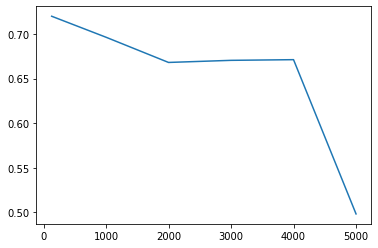

In [40]:
plt.plot(n_samples,accuracies)
plt.show()

In [41]:
n_samples,accuracies

([130, 1000, 2000, 3000, 4000, 5000],
 [0.72,
  0.6964285714285714,
  0.6681428571428571,
  0.6705079365079365,
  0.6712619047619047,
  0.4981333333333333])

## Totali Distretti

In [42]:
from defuzzification import *
from functools import partial

In [43]:
be1 = FuzzyInductor(fuzzifier=ExponentialFuzzifier,c=0.1,k=HyperbolicKernel(1,1))
bes = [be1,be1]

classes = (1,0)
scaling = StandardScaler()
X = dataset[['Tot Testa','Tot Torace','Tot Addome','Tot Scheletro']].values

In [49]:
"""
n_samples = []
accuracies = []
n_samples.append(len(X))
accuracies.append(.72)

for elements in [250,500,1000,1500,2000,2500]:
    smote = SMOTE(sampling_strategy = {0: elements,1:elements})
    X_os,y_os = smote.fit_resample(X,y)
    X_os_std = StandardScaler().fit_transform(X_os)
    perf_train, perf_test = best_estimator_holdout(bes,pd.DataFrame(X_os_std).index,X_os_std, y_os,
                                              classes,0.7,partial(alpha_cut,.45,0),5)
    err = (perf_train + perf_test)/2
    accuracy = 1-err
    n_samples.append(len(X_os))
    accuracies.append(accuracy)
    print(len(X_os),accuracy)
    if accuracy>=0.98: break
"""

'\nn_samples = []\naccuracies = []\nn_samples.append(len(X))\naccuracies.append(.72)\n\nfor elements in [250,500,1000,1500,2000,2500]:\n    smote = SMOTE(sampling_strategy = {0: elements,1:elements})\n    X_os,y_os = smote.fit_resample(X,y)\n    X_os_std = StandardScaler().fit_transform(X_os)\n    perf_train, perf_test = best_estimator_holdout(bes,pd.DataFrame(X_os_std).index,X_os_std, y_os,\n                                              classes,0.7,partial(alpha_cut,.45,0),5)\n    err = (perf_train + perf_test)/2\n    accuracy = 1-err\n    n_samples.append(len(X_os))\n    accuracies.append(accuracy)\n    print(len(X_os),accuracy)\n    if accuracy>=0.98: break\n'

In [45]:
n_samples,accuracies

([130, 500, 1000, 2000, 3000, 4000, 5000],
 [0.72,
  0.6504761904761904,
  0.6742857142857143,
  0.6762619047619047,
  0.6736349206349206,
  0.6824166666666667,
  0.6769047619047619])

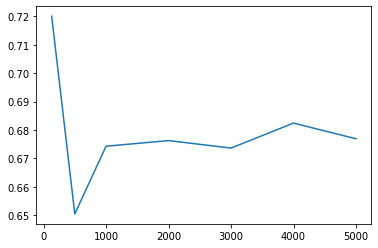

In [46]:
plt.plot(n_samples,accuracies)
plt.show()